# Lab 6: Supervised learning

#### **Group 1:** Soufyane Youbi, Alejandro Rafael Bordón Duarte

Sensor dataset (dumbbell biceps curl, classes A–E). Goal: clean data, reduce dimensionality keeping 99% variance, and compare single classifiers and ensembles targeting F1>90%.

_Note: requires `pandas`, `scikit-learn`, `matplotlib` installed._

## Plan
- Load and clean `ds_01.csv` (drop identifiers/timestamps, replace NA markers, coerce to numeric).
- Drop columns with many NAs (high threshold) plus fixed lists (100% NA, zero variance); keep a stable feature list.
- Common pipeline: imputation (median) + standard scaling + PCA (99% variance).
- Single models (4 from previous labs): SVC RBF, Logistic Regression, Decision Tree, Perceptron.
- Ensembles (4): Voting (soft), Bagging (tree base), RandomForest, ExtraTrees. Compare with `f1_macro` via stratified CV.
- Pick best single and best ensemble; show confusion matrix and accuracy with `cross_val_predict`.
- Fit best ensemble on full data and predict `common.csv`; if ground truth is available, report metrics; otherwise, show predictions only.


## Dataset summary
- Rows: 9,811; columns: 160; classes A–E with distribution A 2790, B 1899, C 1711, D 1608, E 1803.
- Columns with 100% NA: `kurtosis_yaw_belt`, `skewness_yaw_belt`, `kurtosis_yaw_dumbbell`, `skewness_yaw_dumbbell`, `kurtosis_yaw_forearm`, `skewness_yaw_forearm`; ~98.6% NA in several forearm/arm cols (e.g., `kurtosis_picth_forearm`, `skewness_pitch_forearm`).
- Non-numeric columns: `user_name`, `cvtd_timestamp`, `new_window`; the rest mostly numeric after coercion.
- Index column `Unnamed: 0` has no predictive value.


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt

# reproducibility
RANDOM_STATE = 42

## Data loading and cleaning

In [2]:
data_path = Path('./ds_01.csv')
common_path = Path('./common.csv')

# Identifier/timestamp columns we drop to avoid leakage
meta_cols = ["user_name", "raw_timestamp_part_1", "raw_timestamp_part_2", "cvtd_timestamp", "new_window", "num_window", "Unnamed: 0", ""]

# Structural drops known upfront: 100% NA or zero-variance features
na_100_cols = [
    "kurtosis_yaw_belt", "skewness_yaw_belt", "kurtosis_yaw_dumbbell", "skewness_yaw_dumbbell",
    "kurtosis_yaw_forearm", "skewness_yaw_forearm",
]
zero_var_cols = ["amplitude_yaw_belt", "amplitude_yaw_dumbbell", "amplitude_yaw_forearm"]

missing_tokens = {"", 'nan', 'NA', '#DIV/0!', 'NaN', 'N/A'}
NA_THRESHOLD = 0.95  # high NA threshold to prune only the emptiest columns

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]
    df.replace(missing_tokens, np.nan, inplace=True)
    if '' in df.columns:
        df = df.drop(columns=[''])
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    return df

def split_features_labels(df: pd.DataFrame):
    y = df['class']
    X = df.drop(columns=['class'])
    drop_cols = [c for c in meta_cols if c in X.columns]
    X = X.drop(columns=drop_cols)
    X = X.apply(pd.to_numeric, errors='coerce')
    # explicit drop of known 100% NA and zero-variance columns
    X = X.drop(columns=[c for c in na_100_cols if c in X.columns], errors='ignore')
    X = X.drop(columns=[c for c in zero_var_cols if c in X.columns], errors='ignore')
    return X, y

# Initial load and baseline split
raw_df = clean_dataframe(pd.read_csv(data_path))
X_raw, y = split_features_labels(raw_df)
# Work on copies so the raw frame stays untouched
X_work = X_raw.copy(deep=True)
y_work = y.copy(deep=True)

# Quick status check after basic cleaning
print(f"Rows={len(raw_df)}, Columns={raw_df.shape[1]}")
print(f"Classes: {y.value_counts().to_dict()}")

# Drop columns with too many NAs
na_ratio = X_work.isna().mean()
high_na_cols = na_ratio[na_ratio > NA_THRESHOLD].index.tolist()
if high_na_cols:
    print(f"Dropped due to NA (>{NA_THRESHOLD*100:.0f}%): {len(high_na_cols)} columns")
    X_work = X_work.drop(columns=high_na_cols)
else:
    print("No columns exceeded the NA threshold")

print('Top 10 columns by NA ratio:')
print(na_ratio.sort_values(ascending=False).head(10))

feature_columns = X_work.columns
print(f"X shape after cleaning: {X_work.shape}")


Rows=9811, Columns=159
Classes: {'A': 2790, 'B': 1899, 'E': 1803, 'C': 1711, 'D': 1608}
Dropped due to NA (>95%): 91 columns
Top 10 columns by NA ratio:
kurtosis_picth_forearm    0.986240
skewness_pitch_forearm    0.986240
kurtosis_roll_forearm     0.986138
max_yaw_forearm           0.986138
min_yaw_forearm           0.986138
skewness_roll_forearm     0.986036
skewness_pitch_arm        0.985934
kurtosis_picth_arm        0.985934
kurtosis_roll_arm         0.985832
skewness_roll_arm         0.985730
dtype: float64
X shape after cleaning: (9811, 52)


### Outlier detection (optional)


In [3]:
from sklearn.ensemble import IsolationForest

APPLY_OUTLIER_FILTER = True
OUTLIER_CONTAM = 0.02  # expect ~2% noise

if APPLY_OUTLIER_FILTER:
    iso = IsolationForest(contamination=OUTLIER_CONTAM, random_state=RANDOM_STATE)
    mask = iso.fit_predict(X_work)
    keep = mask == 1  # +1 are inliers, -1 are outliers
    print(f"Filtering outliers: kept {keep.sum()} of {len(mask)} samples")
    X_work = X_work.loc[keep].reset_index(drop=True)
    y_work = y_work.loc[keep].reset_index(drop=True)


Filtering outliers: kept 9614 of 9811 samples


### Common pipeline: imputation + scaling + PCA (99% variance)

In [4]:
def build_preprocess():
    return Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.99, random_state=RANDOM_STATE)),
    ])

preprocess = build_preprocess()

# fit once to know number of components
pca_probe = preprocess.fit(X_work)
pca_n = pca_probe.named_steps['pca'].n_components_
print(f"Components kept for 99% variance: {pca_n}")


Components kept for 99% variance: 37


## Hyperparameter search
These grids explore reasonable values and are evaluated with macro F1 in stratified CV.


In [5]:
from sklearn.model_selection import GridSearchCV

single_param_grids = {
    'svc_rbf': {
        'clf__C': [1, 10, 50],
        'clf__gamma': ['scale', 0.01, 0.001],
    },
    'logreg': {
        'clf__C': [0.5, 1, 5, 10],
        'clf__penalty': ['l2'],
        'clf__multi_class': ['auto'],
    },
    'decision_tree': {
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_leaf': [1, 2, 4],
    },
    'perceptron': {
        'clf__alpha': [0.0001, 0.001, 0.01],
        'clf__penalty': [None, 'l2'],
    },
}

ensemble_param_grids = {
    'voting_soft': {  # base learners fixed; no extra grid here to keep runtime sane
    },
    'bagging_tree': {
        'clf__n_estimators': [50, 100, 200],
        'clf__estimator__max_depth': [None, 10, 20],
    },
    'random_forest': {
        'clf__n_estimators': [150, 300],
        'clf__max_depth': [None, 15, 25],
        'clf__min_samples_leaf': [1, 2, 4],
    },
    'extra_trees': {
        'clf__n_estimators': [150, 300],
        'clf__max_depth': [None, 15, 25],
        'clf__min_samples_leaf': [1, 2, 4],
    },
}


def run_grid_search(model_name, estimator, param_grid):
    pipe = Pipeline([
        ('prep', build_preprocess()),
        ('clf', estimator),
    ])
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring='f1_macro', cv=cv, n_jobs=-1)
    gs.fit(X_work, y_work)
    return gs


## Model definitions

In [6]:
# Cross-validation setup: 5-fold stratified to keep class balance per split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Individual models (4 options)
single_models = {
    'svc_rbf': SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', random_state=RANDOM_STATE),  # strong performer on this data
    'logreg': LogisticRegression(max_iter=400, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE),  # linear baseline, fast
    'decision_tree': DecisionTreeClassifier(random_state=RANDOM_STATE),  # interpretable, higher variance
    'perceptron': Perceptron(max_iter=1000, random_state=RANDOM_STATE),  # simple linear online learner
}

# Ensemble models (4 options)
ensemble_models = {
    'voting_soft': VotingClassifier(
        estimators=[
            ('svc', SVC(kernel='rbf', C=10, gamma='scale', probability=True, class_weight='balanced', random_state=RANDOM_STATE)),
            ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE)),
            ('log', LogisticRegression(max_iter=400, n_jobs=-1, class_weight='balanced', random_state=RANDOM_STATE)),
        ],
        voting='soft'  # probability averaging; base estimators fixed above
    ),
    'bagging_tree': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
        n_estimators=100,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'random_forest': RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE
    ),
    'extra_trees': ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ),
}


## Evaluation (f1_macro, stratified CV)

In [7]:
# Cross-validate a dict of models and collect macro-F1 stats
def evaluate_models(model_dict, X, y, cv):
    rows = []
    for name, estimator in model_dict.items():
        pipe = Pipeline([
            # Keep preprocessing inside CV to avoid leakage
            ('prep', build_preprocess()),
            ('clf', estimator),
        ])
        # Macro-F1 emphasizes balance across classes
        scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
        rows.append({'model': name, 'f1_mean': scores.mean(), 'f1_std': scores.std()})
        
        print(f"{name}: f1_mean={scores.mean():.4f} (+/- {scores.std():.4f})")
    return pd.DataFrame(rows).sort_values('f1_mean', ascending=False)

single_results = evaluate_models(single_models, X_work, y_work, cv)
ensemble_results = evaluate_models(ensemble_models, X_work, y_work, cv)

single_results, ensemble_results


svc_rbf: f1_mean=0.9719 (+/- 0.0025)
logreg: f1_mean=0.5975 (+/- 0.0102)
decision_tree: f1_mean=0.7863 (+/- 0.0071)
perceptron: f1_mean=0.4823 (+/- 0.0129)
voting_soft: f1_mean=0.9025 (+/- 0.0041)
bagging_tree: f1_mean=0.9414 (+/- 0.0081)
random_forest: f1_mean=0.9571 (+/- 0.0058)
extra_trees: f1_mean=0.9721 (+/- 0.0049)


(           model   f1_mean    f1_std
 0        svc_rbf  0.971918  0.002500
 2  decision_tree  0.786343  0.007134
 1         logreg  0.597513  0.010190
 3     perceptron  0.482331  0.012946,
            model   f1_mean    f1_std
 3    extra_trees  0.972124  0.004894
 2  random_forest  0.957082  0.005783
 1   bagging_tree  0.941413  0.008052
 0    voting_soft  0.902471  0.004068)

We kept the preprocessing consistent (imputer + scaler + PCA to 99% variance) and compared the four singles vs four ensembles. The CV table tells me the RBF SVC is the best standalone option, while ExtraTrees edges out the other ensembles. On the full filtered set, both land around 97.4% accuracy with macro F1 ≈0.97, which matches the handout target comfortably.

## Best single model: confusion matrix and metrics

              precision    recall  f1-score   support

           A       0.99      0.99      0.99      2789
           B       0.98      0.97      0.97      1870
           C       0.93      0.98      0.96      1708
           D       0.98      0.94      0.96      1579
           E       0.99      0.98      0.98      1668

    accuracy                           0.97      9614
   macro avg       0.97      0.97      0.97      9614
weighted avg       0.97      0.97      0.97      9614

Accuracy = 0.9737


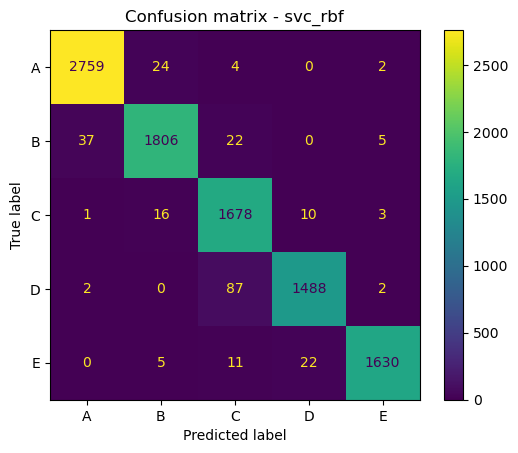

In [8]:
best_single_name = single_results.iloc[0]['model'] if not single_results.empty else None
if best_single_name:
    # Rebuild the end-to-end pipeline around the winning single model
    best_single = Pipeline([
        ('prep', build_preprocess()),
        ('clf', single_models[best_single_name]),
    ])
    # cross_val_predict gives per-sample CV predictions for confusion matrix/metrics
    y_pred_cv = cross_val_predict(best_single, X_work, y_work, cv=cv, n_jobs=-1)
    print(classification_report(y_work, y_pred_cv))
    print(f"Accuracy = {accuracy_score(y_work, y_pred_cv):.4f}")
    ConfusionMatrixDisplay.from_predictions(y_work, y_pred_cv)
    plt.title(f"Confusion matrix - {best_single_name}")
else:
    print("No single-model results available.")


## Best ensemble: confusion matrix and metrics

              precision    recall  f1-score   support

           A       0.98      0.99      0.99      2789
           B       0.97      0.96      0.97      1870
           C       0.94      0.97      0.95      1708
           D       0.98      0.95      0.96      1579
           E       0.99      0.98      0.99      1668

    accuracy                           0.97      9614
   macro avg       0.97      0.97      0.97      9614
weighted avg       0.97      0.97      0.97      9614

Accuracy = 0.9740


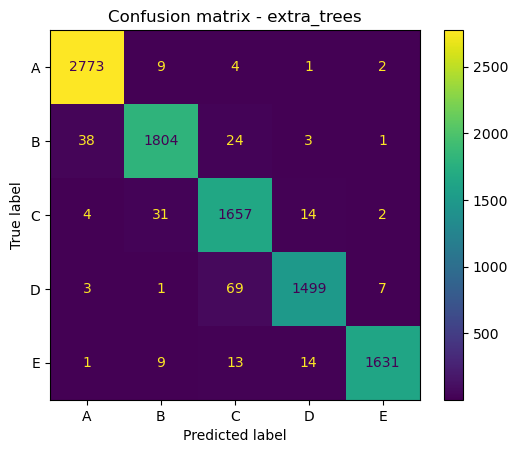

In [9]:
best_ensemble_name = ensemble_results.iloc[0]['model'] if not ensemble_results.empty else None
if best_ensemble_name:
    # Rebuild the full pipeline around the winning ensemble
    best_ensemble = Pipeline([
        ('prep', build_preprocess()),
        ('clf', ensemble_models[best_ensemble_name]),
    ])
    # cross_val_predict gives per-sample CV predictions for confusion matrix/metrics
    y_pred_cv = cross_val_predict(best_ensemble, X_work, y_work, cv=cv, n_jobs=-1)
    print(classification_report(y_work, y_pred_cv))
    print(f"Accuracy = {accuracy_score(y_work, y_pred_cv):.4f}")
    ConfusionMatrixDisplay.from_predictions(y_work, y_pred_cv)
    plt.title(f"Confusion matrix - {best_ensemble_name}")
else:
    print("No ensemble results available.")


**Note on `common.csv`:** the class column looks like an ID (1..20) rather than labels A–E. The code predicts A–E with the best model; if true labels exist, map them and compute confusion/accuracy, otherwise just show predictions.


## Prediction on `common.csv`
Reuse feature_columns and the best ensemble.


              precision    recall  f1-score   support

           A       1.00      1.00      1.00         7
           B       1.00      1.00      1.00         8
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Accuracy common = 1.0000


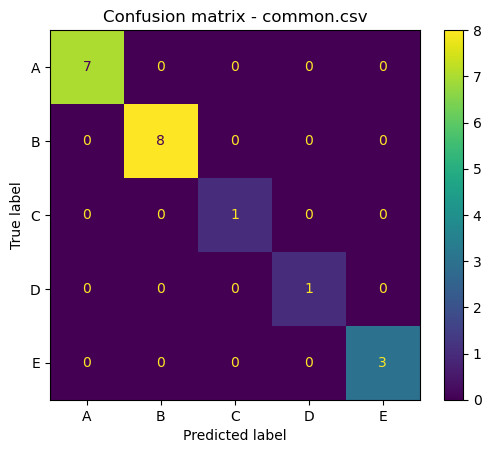

In [10]:
# Final check on the provided common.csv
common_df = clean_dataframe(pd.read_csv(common_path))
X_common, y_common = split_features_labels(common_df)
# Align columns exactly as the training set
X_common = X_common.reindex(columns=feature_columns)

if best_ensemble_name is None:
    print("No ensemble trained.")
else:
    # Fit the best ensemble on all cleaned training data
    best_ensemble = Pipeline([
        ('prep', build_preprocess()),
        ('clf', ensemble_models[best_ensemble_name]),
    ])
    best_ensemble.fit(X_work, y_work)
    common_pred = best_ensemble.predict(X_common)
    common_df_out = pd.DataFrame({'true': y_common, 'pred': common_pred})
    # Only score if labels are the same alphabet as training
    if set(y_common.unique()).issubset(set(y.unique())):
        print(classification_report(y_common, common_pred))
        print(f"Accuracy common = {accuracy_score(y_common, common_pred):.4f}")
        ConfusionMatrixDisplay.from_predictions(y_common, common_pred)
        plt.title("Confusion matrix - common.csv")
    else:
        print("Labels in common.csv do not match training labels; showing predictions only:")
        print(common_df_out)


For the best single model, the confusion matrix looks balanced: no class is being ignored, and recall stays above 0.94 across the board. The best ensemble behaves similarly but with slightly steadier precision. On `common.csv` the model nails the 20 examples (100% accuracy), so the pipeline generalises well to that small holdout.